In [1]:
import sys
import os
sys.path.insert(0,'/Users/adam/Project/NIKA/Software/Processing/Labtools/RA/pitszi/')

import numpy as np
from scipy.ndimage import gaussian_filter, fourier_gaussian
import matplotlib.pyplot as plt
import scipy.stats as stats
import time
from pitszi import utils

# Relevant fonctions

In [2]:
# Pixel window function
def pix_mn(k2d_x, k2d_y, reso):
    term1 = np.sinc(k2d_x*reso)
    term2 = np.sinc(k2d_y*reso)
    pix_mn = term1 * term2
    return pix_mn

In [3]:
# Pixel window function
def beam_mn(k2d_x, k2d_y, reso, FWHM):
    sigma2fwhm = 2 * np.sqrt(2*np.log(2))
    sigma = FWHM / sigma2fwhm
    k_0 = 1 / (np.sqrt(2) * np.pi * sigma)
    G_k = np.exp(-(k2d_x**2 + k2d_y**2) / k_0**2)
    return G_k

In [4]:
# Equation A.6
def compute_K(W):
    Nx, Ny = W.shape
    K = np.zeros((Nx, Ny, Nx, Ny), dtype=complex)  # m,n,m1,n1
    
    for n1 in range(Ny):
        for m1 in range(Nx):
            for n in range(Ny):
                for m in range(Nx):
                    if m1 <= m and n1 <= n:
                        K[m, n, m1, n1] = W[m - m1, n - n1,]
                    elif m1 <= m and n1 > n:
                        K[m, n, m1, n1] = W[m - m1, Ny + n - n1]
                    elif m1 > m and n1 <= n:
                        K[m, n,  m1, n1] = W[Nx + m - m1, n - n1]
                    elif m1 > m and n1 > n:
                        K[m, n, m1, n1] = W[Nx + m - m1, Ny + n - n1]
    return K

# Equation A.5
def prod_K(K, T):
    Nx, Ny = T.shape
    O = np.zeros((Nx, Ny), dtype=complex)  # m,n
    
    for n in range(Ny):
        for m in range(Nx):
            O[m, n] = np.sum(K[m, n, :, :] * T) / Nx/Ny
    return O

In [5]:
# Equation 11, 12
def compute_RQ(k2d, kedge, beta=0):
    Nx, Ny = k2d.shape
    Nb = len(kedge)-1
    R = np.zeros((Nx, Ny, Nb))
    Q = np.zeros((Nx, Ny, Nb))
    
    for b in range(Nb):
        wbin = (k2d >= kedge[b]) * (k2d < kedge[b+1])
        sigma = np.sum(wbin) # Number of kmn falling in bin
        for n in range(Ny):
            for m in range(Nx):
                cond = (kedge[b] <= k2d[m,n]) and (kedge[b+1] > k2d[m,n])
                if cond:
                    if beta == 0:
                        R[m,n, b] = 1.0 / sigma 
                        Q[m,n, b] = 1.0
                    else:
                        R[m,n, b] = k2d[m,n]**beta / sigma
                        Q[m,n, b] = 1/k2d[m,n]**beta
                else:
                    R[m,n, b] = 0.0
                    Q[m,n, b] = 0.0
    return R, Q

In [6]:
def compute_Mbb_direct(K, R, Q, k2d, kedges, w_mn):
    
    Nx, Ny = K.shape[0], K.shape[1]
    Nb = len(kedges)-1
    idx_bin = np.linspace(0,len(kedge)-2,len(kedge)-1, dtype=int)
    
    mtt_bb = np.zeros((Nb, Nb))

    for m in range(Nx):
        for n in range (Ny):
            w = (k2d[m,n] >= kedge[0:-1]) * (k2d[m,n] < kedge[1:])
            nw = np.sum(w)
            if nw == 1:
                b = idx_bin[w][0]
                p = R[m,n,b]
    
                for m1 in range(Nx):
                    for n1 in range (Ny):
                        w1 = (k2d[m1,n1] >= kedge[0:-1]) * (k2d[m1,n1] < kedge[1:])
                        nw1 = np.sum(w1)
                        if nw1 == 1:
                            b1 = idx_bin[w1][0]
                            q = Q[m1,n1,b1]
                            
                            mtt_bb[b1,b] = mtt_bb[b1,b] + p*np.abs(K[m,n,m1,n1])**2*q
    return mtt_bb.T / (Nx*Ny)**2


def compute_Mbb(R, K, Q):
    Nx, Ny = R.shape[0], R.shape[1]
    Nb = R.shape[2]
    Mbb = np.zeros((Nb, Nb))
    for ib in range(Nb):
        for jb in range(Nb):            
                sum_KQ  = np.sum(np.abs(K)**2 * (Q[:,:,jb])[np.newaxis, np.newaxis, :, :], axis=(2,3))
                sum_RKQ = np.sum(R[:,:,ib] * sum_KQ)
                Mbb[ib, jb] = sum_RKQ
    return Mbb/(Nx*Ny)**2

# Define the data

### Mask definition and image parameters

In [7]:
# Map size and reso
Nx, Ny = 41, 41 # Number of pixel
reso = 5.0      # Resolution in arcsec
mapscale = 1.8    # Increase the map size by this factor for aliasing purpose
mask_rad = Nx*reso/2

# Smoothing
smooth_mask = 10 # Mask smoothing FWHM in arcsec
FWHM_w8 = 130    # FWHM of the gaussian weight function

# Input Pk
Lcut = 60000.0        # Injection cut in arcsec
beta_spec = 11.0/3  # Spectral index for the modelign
beta_bin = 0#11.0/3        # Spectral index for the bining
kpiv = 0.05          # k at which Pk is normalized
norm = 1            # Normalization of Pk

# Pk binning
binscale = 'lin'
Nbin = 10
binkmin = 2/(Nx*reso)
binkmax = 1/(2*reso)

# Info
print('FoV = ', reso*Nx, ',  ', reso*Ny, ' arcsec')

FoV =  205.0 ,   205.0  arcsec


In [8]:
# Number of pixels to add on each side to avoid aliasing effects
Nx_add = int((Nx*mapscale-Nx)/2)
Ny_add = int((Ny*mapscale-Ny)/2)
Nx_tot, Ny_tot = int(Nx + 2*Nx_add), int(Ny + 2*Ny_add)

print(Nx_add, Ny_add, Nx_tot, Ny_tot)

16 16 73 73


In [9]:
# Bining and k definition
k_x = np.fft.fftfreq(Nx, reso)
k_y = np.fft.fftfreq(Ny, reso)
k2d_x, k2d_y = np.meshgrid(k_x, k_y, indexing='ij')
k2d = np.sqrt(k2d_x**2 + k2d_y**2)

if binkmin is None:
    kmin = np.amin(k2d[k2d > 0])
else:
    kmin = binkmin
if binkmax is None:
    kmax = np.amax(k2d)
else:
    kmax = binkmax
    
if binscale == 'lin': kedge = np.linspace(kmin, kmax, Nbin+1)
if binscale == 'log': kedge = np.logspace(np.log10(kmin), np.log10(kmax), Nbin+1)
kvals = 0.5 * (kedge[1:] + kedge[:-1])

kbin_counts, _, _  = stats.binned_statistic(k2d.flatten(), k2d.flatten(), statistic="count", bins=kedge)
print(kbin_counts)

k_x_tot = np.fft.fftfreq(Nx_tot, reso)
k_y_tot = np.fft.fftfreq(Ny_tot, reso)
k2d_x_tot, k2d_y_tot = np.meshgrid(k_x_tot, k_y_tot, indexing='ij')
k2d_tot = np.sqrt(k2d_x_tot**2 + k2d_y_tot**2)

[ 36.  56.  76. 100. 124. 144. 152. 188. 208. 220.]


In [10]:
# Mask definition
mask = np.zeros((Nx, Ny))+1
mask_tot = np.zeros((Nx_tot, Ny_tot))+1

x = np.linspace(-Nx/2*reso, +Nx/2*reso, Nx)
y = np.linspace(-Ny/2*reso, +Ny/2*reso, Ny)
x2d, y2d = np.meshgrid(x, y, indexing='ij')
rad = np.sqrt(x2d**2 + y2d**2)

x_tot = np.linspace(-Nx_tot/2*reso, +Nx_tot/2*reso, Nx_tot)
y_tot = np.linspace(-Ny_tot/2*reso, +Ny_tot/2*reso, Ny_tot)
x2d_tot, y2d_tot = np.meshgrid(x_tot, y_tot, indexing='ij')
rad_tot = np.sqrt(x2d_tot**2 + y2d_tot**2)

# Always mask outside pixels
mask[rad > mask_rad] = 0
mask_tot[rad_tot > mask_rad] = 0
mask_tot[0:Nx_add, :] = 0
mask_tot[Nx_tot-Nx_add:, :] = 0
mask_tot[:, 0:Ny_add] = 0
mask_tot[:, Ny_tot-Ny_add:] = 0

if smooth_mask>0:
    FT_mask = np.fft.fft2(mask)
    FT_mask = fourier_gaussian(FT_mask, sigma=smooth_mask/(2*np.sqrt(2*np.log(2)))/reso)
    mask = np.real(np.fft.ifft2(FT_mask))
    
    FT_mask_tot = np.fft.fft2(mask_tot)
    FT_mask_tot = fourier_gaussian(FT_mask_tot, sigma=smooth_mask/(2*np.sqrt(2*np.log(2)))/reso)
    mask_tot = np.real(np.fft.ifft2(FT_mask_tot))

# Weight definition
w8 = np.exp(-rad**2/2/(FWHM_w8/(2*np.sqrt(2*np.log(2))))**2)
w8_tot = np.exp(-rad_tot**2/2/(FWHM_w8/(2*np.sqrt(2*np.log(2))))**2)
#w8 = 1/(1+rad/10)**2
#w8_tot =1/(1+rad_tot/10)**2

# Total weight
mask_w8 = mask #* w8
fft_mask_w8  = np.fft.fftn(mask_w8)
mask_w8_tot = mask_tot #* w8_tot
fft_mask_w8_tot  = np.fft.fftn(mask_w8_tot)

Text(0.5, 1.0, 'Weight tot')

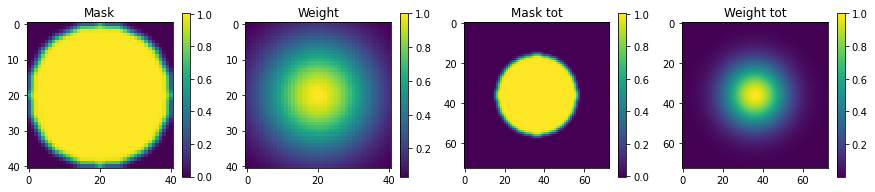

In [11]:
plt.figure(2, figsize=(15,3))
plt.subplot(1,4,1)
plt.imshow(mask)
plt.colorbar()
plt.title('Mask')

plt.subplot(1,4,2)
plt.imshow(w8)
plt.colorbar()
plt.title('Weight')

plt.subplot(1,4,3)
plt.imshow(mask_tot)
plt.colorbar()
plt.title('Mask tot')

plt.subplot(1,4,4)
plt.imshow(w8_tot)
plt.colorbar()
plt.title('Weight tot')

In [12]:
# Compute K matrix
start = time.time()
K = compute_K(fft_mask_w8)
K_tot = compute_K(fft_mask_w8_tot)
end = time.time()
print('Computing time K (s):', end - start)

# Compute R,Q matrix
start = time.time()
R, Q = compute_RQ(k2d, kedge, beta=beta_bin)
R_tot, Q_tot = compute_RQ(k2d_tot, kedge, beta=beta_bin)
end = time.time()
print('Computing time R,Q (s):', end - start)

# Compute Mbb matrix
start = time.time()
Mbb = compute_Mbb(R, K, Q)
Mbb_tot = compute_Mbb(R_tot, K_tot, Q_tot)
end = time.time()
print('Computing time Mbb (s):', end - start)

#start = time.time()
#Mbb_direct = compute_Mbb_direct(K, R, Q, k2d, kedge, fft_mask_w8)
#Mbb_direct_tot = compute_Mbb_direct(K_tot, R_tot, Q_tot, k2d_tot, kedge, fft_mask_w8_tot)
#end = time.time()
#print('Computing time Mbb_direct (s):', end - start)

Computing time K (s): 11.806379795074463
Computing time R,Q (s): 0.057126760482788086
Computing time Mbb (s): 40.36085915565491


Text(0.5, 1.0, 'Mbb tot')

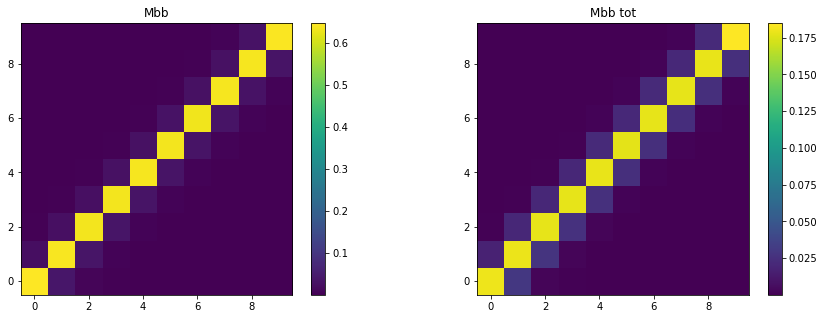

In [13]:
# Show Mbb matrix
plt.figure(1, figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(Mbb, origin='lower')
plt.colorbar()
plt.title('Mbb')

plt.subplot(1,2,2)
plt.imshow(Mbb_tot, origin='lower')
plt.colorbar()
plt.title('Mbb tot')

### Map realization

In [14]:
def input_pk(k):
    return norm * (k/kpiv)**-beta_spec * np.exp(-1/(Lcut*k)**2)

In [15]:
Nmc = 300
Pk_img_mc = np.zeros((Nmc, Nbin))     # |FFT image|^2 with standard bining
Pk_img_tot_mc = np.zeros((Nmc, Nbin)) # |FFT image large|^2 with standard bining
Pk_ixm_mc = np.zeros((Nmc, Nbin))     # |FFT image x mask|^2 with standard bining
Pk_ixm_tot_mc = np.zeros((Nmc, Nbin)) # |FFT image x mask large|^2 with standard bining
Pk2d_ixm_mc = np.zeros((Nmc, Nx, Ny))     # |FFT image x mask|^2 in 2D
Pk2d_ixm_tot_mc = np.zeros((Nmc, Nx_tot, Ny_tot)) # |FFT image x mask large|^2 in 2D

Pk_RT_mc  = np.zeros((Nmc, Nbin))     # |FFT image|^2 convolved with binning matrix R
Pk_RT_tot_mc  = np.zeros((Nmc, Nbin)) # |FFT image large|^2 convolved with binning matrix R

Pk_D_mc   = np.zeros((Nmc, Nbin))     # |FFT image|^2 multiplied by K matrix and then with standard bining
Pk_D_tot_mc   = np.zeros((Nmc, Nbin)) # |FFT image large|^2 multiplied by K matrix and then with standard bining

Pk_Mbb_mc = np.zeros((Nmc, Nbin))     # |FFT image|^2 convolved with binning matrix R and multiplied by Mbb to mimic mask
Pk_Mbb_tot_mc = np.zeros((Nmc, Nbin)) # |FFT image large|^2 convolved with binning matrix R and multiplied by Mbb to mimic mask

for imap in range(Nmc):
    # Compute the map
    amplitude = input_pk(k2d_tot)
    amplitude[k2d_tot == 0] = 0
    image = np.random.normal(0,1, (Nx_tot, Ny_tot))
    fftfield = np.fft.fftn(image) * np.sqrt(amplitude / reso**2)
    image_tot = np.real(np.fft.ifftn(fftfield))
    image = image_tot[Nx_add:Nx_tot-Nx_add, Ny_add:Ny_tot-Ny_add]
    
    # FFT
    fft_ixm_tot = np.fft.fftn(image_tot*mask_w8_tot) * np.sqrt(reso**2/Nx_tot/Ny_tot)
    fft_ixm = np.fft.fftn(image*mask_w8) * np.sqrt(reso**2/Nx/Ny)
    fft_img_tot = np.fft.fftn(image_tot) * np.sqrt(reso**2/Nx_tot/Ny_tot)
    fft_img = np.fft.fftn(image) * np.sqrt(reso**2/Nx/Ny)
    #fft_ixm_tot = np.fft.fftn(image_tot*mask_w8_tot - np.mean(image_tot*mask_w8_tot)) * np.sqrt(reso**2/Nx_tot/Ny_tot)
    #fft_ixm = np.fft.fftn(image*mask_w8 - np.mean(image*mask_w8)) * np.sqrt(reso**2/Nx/Ny)
    #fft_img_tot = np.fft.fftn(image_tot - np.mean(image_tot)) * np.sqrt(reso**2/Nx_tot/Ny_tot)
    #fft_img = np.fft.fftn(image - np.mean(image)) * np.sqrt(reso**2/Nx/Ny)
    
    # Unbinned 2D
    Pk2d_ixm_mc[imap, :,:] = k2d**beta_bin*np.abs(fft_ixm)**2
    Pk2d_ixm_tot_mc[imap, :,:] = k2d_tot**beta_bin*np.abs(fft_ixm_tot)**2
    
    # Bin the Pk
    Pk_ixm, _, _     = stats.binned_statistic(k2d.flatten(),     k2d.flatten()**beta_bin*np.abs(fft_ixm.flatten())**2,         statistic="mean", bins=kedge)
    Pk_ixm_tot, _, _ = stats.binned_statistic(k2d_tot.flatten(), k2d_tot.flatten()**beta_bin*np.abs(fft_ixm_tot.flatten())**2, statistic="mean", bins=kedge)
    Pk_img, _, _     = stats.binned_statistic(k2d.flatten(),     k2d.flatten()**beta_bin*np.abs(fft_img.flatten())**2,         statistic="mean", bins=kedge)
    Pk_img_tot, _, _ = stats.binned_statistic(k2d_tot.flatten(), k2d_tot.flatten()**beta_bin*np.abs(fft_img_tot.flatten())**2, statistic="mean", bins=kedge)
    
    # Compute binned Pk using R matrix
    Pk_RT     = np.sum(R*(np.abs(fft_img)**2)[:,:,np.newaxis], axis=(0,1))
    Pk_RT_tot = np.sum(R_tot*(np.abs(fft_img_tot)**2)[:,:,np.newaxis], axis=(0,1))
    
    # Compute KxFFT_img = sum K # fft (i.e. mask effect without bining)
    KxFFT_img     = prod_K(K,     fft_img)
    KxFFT_img_tot = prod_K(K_tot, fft_img_tot)
    Pk_D, _, _     = stats.binned_statistic(k2d.flatten(),     k2d.flatten()**beta_bin*np.abs(KxFFT_img.flatten())**2,         statistic="mean", bins=kedge)    
    Pk_D_tot, _, _ = stats.binned_statistic(k2d_tot.flatten(), k2d_tot.flatten()**beta_bin*np.abs(KxFFT_img_tot.flatten())**2, statistic="mean", bins=kedge)    
    
    # Compute Mbb x Pk binned via R
    Pk_Mbb     = np.matmul(Mbb, Pk_RT)
    Pk_Mbb_tot = np.matmul(Mbb_tot, Pk_RT_tot)

    # Fill the data
    Pk_ixm_mc[imap,:]     = Pk_ixm
    Pk_ixm_tot_mc[imap,:] = Pk_ixm_tot
    Pk_img_mc[imap,:]     = Pk_img
    Pk_img_tot_mc[imap,:] = Pk_img_tot
    Pk_RT_mc[imap,:]      = Pk_RT
    Pk_RT_tot_mc[imap,:]  = Pk_RT_tot
    Pk_D_mc[imap,:]       = Pk_D
    Pk_D_tot_mc[imap,:]   = Pk_D_tot
    Pk_Mbb_mc[imap,:]     = Pk_Mbb
    Pk_Mbb_tot_mc[imap,:] = Pk_Mbb_tot

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


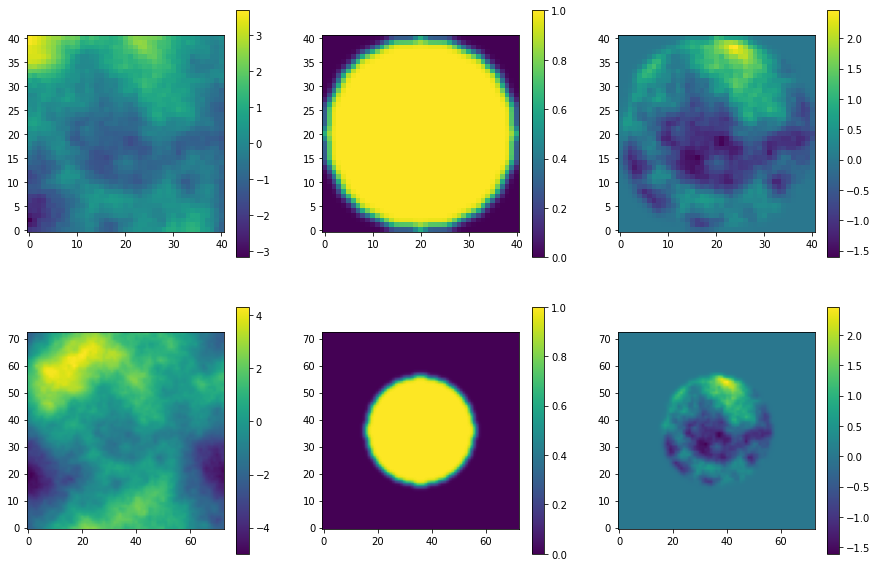

In [16]:
plt.figure(0, figsize=(15,10))
plt.subplot(2,3,1)
plt.imshow(image.T, origin='lower')
plt.colorbar()
plt.subplot(2,3,2)
plt.imshow(mask.T, origin='lower')
plt.colorbar()
plt.subplot(2,3,3)
plt.imshow((image*mask_w8).T, origin='lower')
plt.colorbar()
plt.subplot(2,3,4)
plt.imshow(image_tot.T, origin='lower')
plt.colorbar()
plt.subplot(2,3,5)
plt.imshow(mask_tot.T, origin='lower')
plt.colorbar()
plt.subplot(2,3,6)
plt.imshow((image_tot*mask_w8_tot).T, origin='lower')
plt.colorbar()

### Expected model including same binning

In [17]:
# Unbinned input
input_model = input_pk(k2d)
input_model[k2d == 0] = 0
input_model_tot = input_pk(k2d_tot)
input_model_tot[k2d_tot == 0] = 0

# binned input
input_Pk_binned, _, _     = stats.binned_statistic(k2d.flatten(), k2d.flatten()**beta_bin*input_model.flatten(), statistic="mean", bins=kedge)
input_Pk_binned_tot, _, _ = stats.binned_statistic(k2d_tot.flatten(), k2d_tot.flatten()**beta_bin*input_model_tot.flatten(), statistic="mean", bins=kedge)

# Input processed with K matrix and binned
input_Pk_K_tot = np.abs(prod_K(np.abs(K_tot)**2, input_model_tot)) / Nx_tot / Ny_tot
input_Pk_K     = np.abs(prod_K(np.abs(K)**2, input_model)) / Nx / Ny
input_Pk_K, _, _     = stats.binned_statistic(k2d.flatten(),     k2d.flatten()**beta_bin*input_Pk_K.flatten(),         statistic="mean", bins=kedge)
input_Pk_K_tot, _, _ = stats.binned_statistic(k2d_tot.flatten(), k2d_tot.flatten()**beta_bin*input_Pk_K_tot.flatten(), statistic="mean", bins=kedge)

# Input processed with Mbb
#input_Pk_mbb = np.matmul(Mbb, input_Pk_binned)
#input_Pk_mbb_tot = np.matmul(Mbb_tot, input_Pk_binned)

/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/adam/Project/anaconda3/envs/ctaphys/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


Text(0.5, 1.0, '(MC - model)/MC (%)')

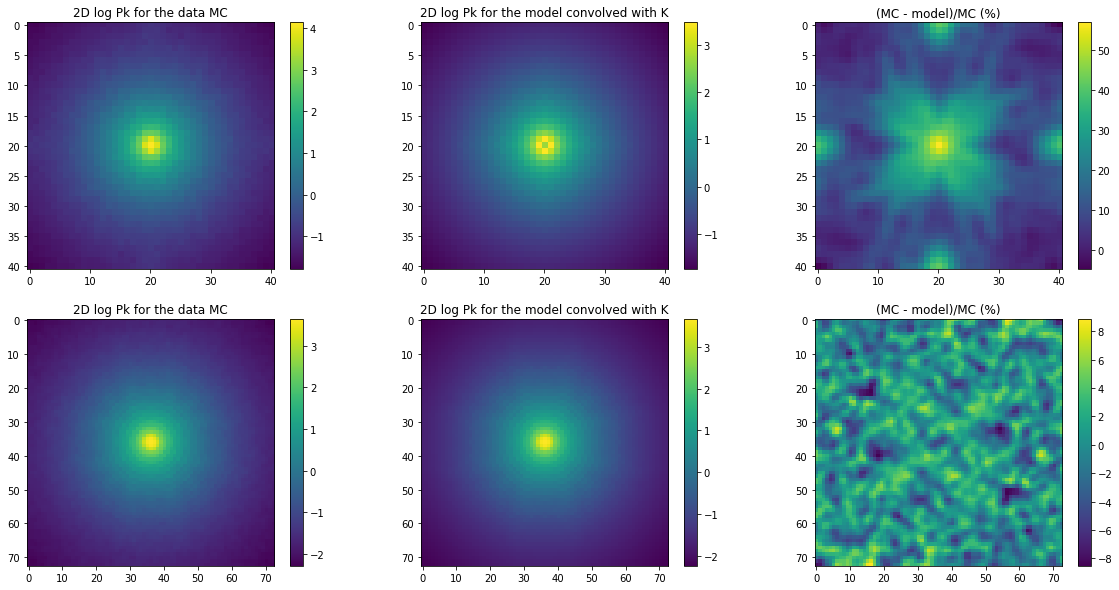

In [18]:
pk2d_ixm_mean = np.mean(Pk2d_ixm_mc, axis=0)
pk2d_model_k = k2d**beta_bin*np.abs(prod_K(np.abs(K)**2, input_model) / Nx / Ny)
pk2d_ixm_tot_mean = np.mean(Pk2d_ixm_tot_mc, axis=0)
pk2d_model_tot_k = k2d_tot**beta_bin*np.abs(prod_K(np.abs(K_tot)**2, input_model_tot) / Nx_tot / Ny_tot)

plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
plt.imshow(np.log10(np.fft.fftshift(pk2d_ixm_mean)))
plt.colorbar()
plt.title('2D log Pk for the data MC')

plt.subplot(2,3,2)
plt.imshow(np.log10(np.fft.fftshift(pk2d_model_k)))
plt.colorbar()
plt.title('2D log Pk for the model convolved with K')

plt.subplot(2,3,3)
plt.imshow(gaussian_filter(100*np.fft.fftshift((pk2d_ixm_mean-pk2d_model_k)/pk2d_ixm_mean), 1))
plt.colorbar()
plt.title('(MC - model)/MC (%)')


plt.subplot(2,3,4)
plt.imshow(np.log10(np.fft.fftshift(pk2d_ixm_tot_mean)))
plt.colorbar()
plt.title('2D log Pk for the data MC')

plt.subplot(2,3,5)
plt.imshow(np.log10(np.fft.fftshift(pk2d_model_tot_k)))
plt.colorbar()
plt.title('2D log Pk for the model convolved with K')

plt.subplot(2,3,6)
plt.imshow(gaussian_filter(100*np.fft.fftshift((pk2d_ixm_tot_mean-pk2d_model_tot_k)/pk2d_ixm_tot_mean), 1))
plt.colorbar()
plt.title('(MC - model)/MC (%)')

array([1.20269456, 1.02205207, 1.02325968, 1.00582001, 0.99505004,
       0.98579391, 0.99639826, 1.00671183, 0.9961465 , 1.00457522])

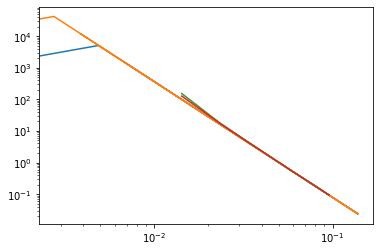

In [19]:
plt.loglog(k2d.flatten(), k2d.flatten()**beta_bin*input_model.flatten())
plt.loglog(k2d_tot.flatten(), k2d_tot.flatten()**beta_bin*input_model_tot.flatten())
plt.loglog(kvals, input_Pk_binned)
plt.loglog(kvals, input_Pk_binned_tot)

input_Pk_binned/input_Pk_binned_tot

# Output the results

### Compute stats

In [20]:
#-----
Pk_img_m = np.mean(Pk_img_mc, axis=0)          # |FFT image|^2 with standard bining
Pk_img_tot_m = np.mean(Pk_img_tot_mc, axis=0)  # |FFT image large|^2 with standard bining
Pk_ixm_m = np.mean(Pk_ixm_mc, axis=0)          # |FFT image x mask|^2 with standard bining
Pk_ixm_tot_m = np.mean(Pk_ixm_tot_mc, axis=0)  # |FFT image x mask large|^2 with standard bining

Pk_ixm_s = np.std(Pk_ixm_mc, axis=0)  
Pk_img_s = np.std(Pk_img_mc, axis=0) 
Pk_ixm_tot_s = np.std(Pk_ixm_tot_mc, axis=0)
Pk_img_tot_s = np.std(Pk_img_tot_mc, axis=0)

#-----
Pk_RT_m      = np.mean(Pk_RT_mc, axis=0)       # |FFT image|^2 convolved with binning matrix R
Pk_RT_tot_m  = np.mean(Pk_RT_tot_mc, axis=0)   # |FFT image large|^2 convolved with binning matrix R

Pk_RT_s      = np.std(Pk_RT_mc, axis=0)
Pk_RT_tot_s  = np.std(Pk_RT_tot_mc, axis=0)

#-----
Pk_D_m     = np.mean(Pk_D_mc, axis=0)     # |FFT image|^2 multiplied by K matrix and then with standard bining
Pk_D_tot_m = np.mean(Pk_D_tot_mc, axis=0) # |FFT image large|^2 multiplied by K matrix and then with standard bining

Pk_D_s     = np.std(Pk_D_mc, axis=0)      # |FFT image|^2 multiplied by K matrix and then with standard bining
Pk_D_tot_s = np.std(Pk_D_tot_mc, axis=0)  # |FFT image large|^2 multiplied by K matrix and then with standard bining

#-----
Pk_Mbb_m = np.mean(Pk_Mbb_mc, axis=0)         # Mbb x R * |FFT image|^2
Pk_Mbb_tot_m = np.mean(Pk_Mbb_tot_mc, axis=0) # Mbb x R * |FFT image|^2

Pk_Mbb_s = np.std(Pk_Mbb_mc, axis=0)         # Mbb x R * |FFT image|^2
Pk_Mbb_tot_s = np.std(Pk_Mbb_tot_mc, axis=0) # Mbb x R * |FFT image|^2

Text(0.5, 1.0, 'Correlation matrix tot')

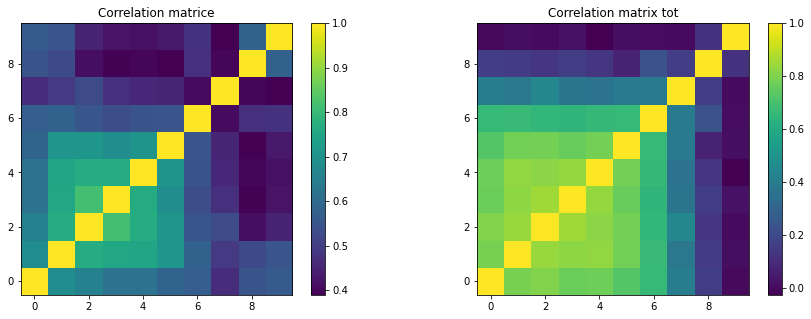

In [21]:
cov_imx = np.zeros((len(kvals), len(kvals)))
cov_imx_tot = np.zeros((len(kvals), len(kvals)))
for imc in range(Nmc):
    cov_imx     += np.matmul((Pk_ixm_mc[imc,:] - Pk_ixm_m)[:,None], (Pk_ixm_mc[imc,:] - Pk_ixm_m)[None,:])
    cov_imx_tot += np.matmul((Pk_ixm_tot_mc[imc,:] - Pk_ixm_tot_m)[:,None], (Pk_ixm_tot_mc[imc,:] - Pk_ixm_tot_m)[None,:])
cov_imx = cov_imx/Nmc
cov_imx_tot = cov_imx_tot/Nmc

plt.figure(0, figsize=(15,5))
plt.subplot(1,2,1)
plt.imshow(utils.correlation_from_covariance(cov_imx), origin='lower')
plt.colorbar()
plt.title('Correlation matrice')
plt.subplot(1,2,2)
plt.imshow(utils.correlation_from_covariance(cov_imx_tot), origin='lower')
plt.colorbar()
plt.title('Correlation matrix tot')

### Pk checks R binning

[ 2.98931915e-16  1.24595836e-16  1.84253285e-16  2.05399538e-16
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  1.66303987e-16 -3.78269235e-16]
[ 0.00000000e+00  2.02814264e-16  0.00000000e+00 -2.16190833e-16
  0.00000000e+00  2.07092119e-16  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
Differrence > 1e-14 for small map:  0
Differrence > 1e-14 for large map:  0


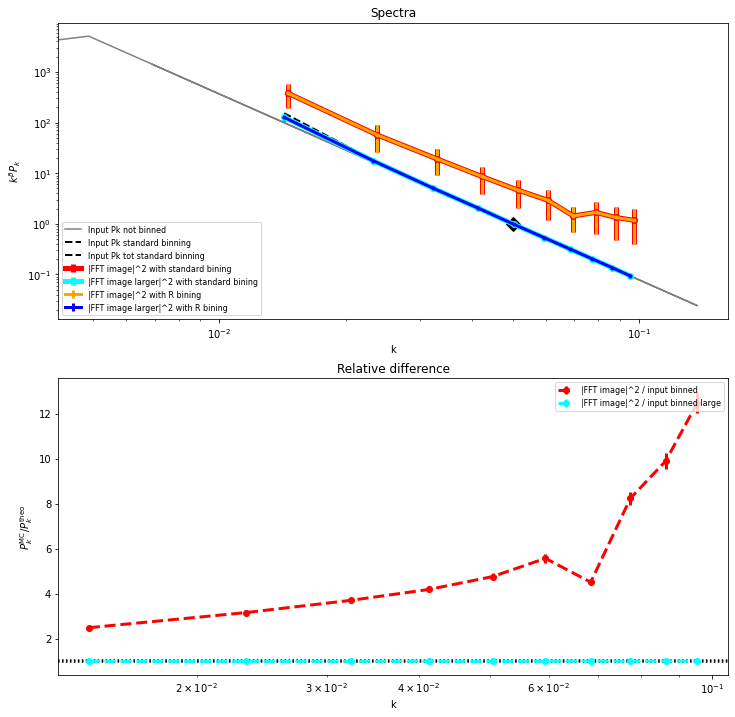

In [22]:
plt.figure(1, figsize=(12,12))
plt.subplot(2,1,1)
plt.errorbar(kvals*1.02, Pk_img_m, Pk_img_s, label='|FFT image|^2 with standard bining', lw=5, marker='o', color='red')
plt.errorbar(kvals, Pk_img_tot_m, Pk_img_tot_s, label='|FFT image larger|^2 with standard bining', lw=5, marker='o', color='cyan')
plt.errorbar(kvals*1.02, Pk_RT_m, Pk_RT_s, label='|FFT image|^2 with R bining', lw=3, marker='.', color='orange')
plt.errorbar(kvals, Pk_RT_tot_m, Pk_RT_tot_s, label='|FFT image larger|^2 with R bining', lw=3, marker='.', color='blue')
plt.loglog(k2d.flatten(), k2d.flatten()**beta_bin*input_model.flatten(), color='grey', label='Input Pk not binned')
plt.loglog(kvals, input_Pk_binned, color='k', lw=2, ls='--',label='Input Pk standard binning')
plt.loglog(kvals, input_Pk_binned_tot, color='k', lw=2, ls='--',label='Input Pk tot standard binning')
plt.plot([kpiv],[kpiv**beta_bin*norm], marker='D', ls='', markersize=10, color='k')
plt.legend(loc= 'lower left', fontsize=8)
plt.xlabel('k')
plt.ylabel(r'$k^{\beta} P_k$')
plt.title('Spectra')

plt.subplot(2,1,2)
plt.errorbar(kvals, Pk_img_m/input_Pk_binned, Pk_img_s/Nmc**0.5/input_Pk_binned, label='|FFT image|^2 / input binned', lw=3, marker='o', ls='--', color='red')
plt.errorbar(kvals, Pk_img_tot_m/input_Pk_binned_tot, Pk_img_tot_s/Nmc**0.5/input_Pk_binned_tot, label='|FFT image|^2 / input binned large', lw=3, marker='o', ls='--', color='cyan')
plt.axhline(1, ls=':', color='k')
plt.axhline(0.95, ls=':', color='k')
plt.axhline(1.05, ls=':', color='k')
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('k')
plt.xscale('log')
plt.ylabel(r'$P^{\rm MC}_k/P^{\rm theo}_k$')
plt.title('Relative difference')

print((Pk_img_m - Pk_RT_m)/Pk_img_m)
print((Pk_img_tot_m - Pk_RT_tot_m)/Pk_img_tot_m)

print('Differrence > 1e-14 for small map: ', np.sum(np.abs((Pk_img_m - Pk_RT_m)/Pk_img_m)>1e-14))
print('Differrence > 1e-14 for large map: ', np.sum(np.abs((Pk_img_tot_m - Pk_RT_tot_m)/Pk_img_tot_m)>1e-14))

### Pk checks with mask and large map or not

Text(0.5, 1.0, 'Relative difference')

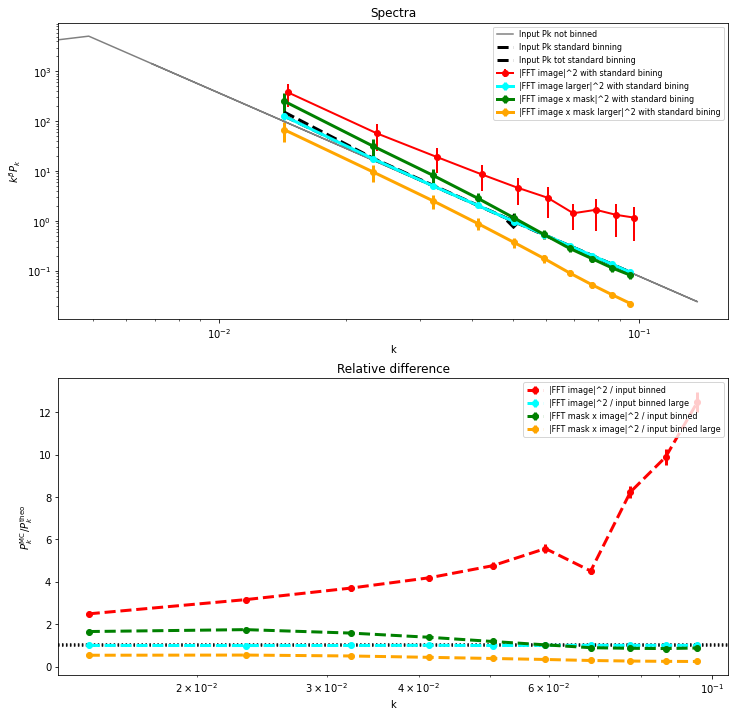

In [23]:
plt.figure(1, figsize=(12,12))
plt.subplot(2,1,1)
plt.errorbar(kvals*1.02, Pk_img_m, Pk_img_s, label='|FFT image|^2 with standard bining', lw=2, marker='o', color='red')
plt.errorbar(kvals, Pk_img_tot_m, Pk_img_tot_s, label='|FFT image larger|^2 with standard bining', lw=3, marker='o', color='cyan')
plt.errorbar(kvals, Pk_ixm_m, Pk_ixm_s, label='|FFT image x mask|^2 with standard bining', lw=3, marker='o', color='green')
plt.errorbar(kvals, Pk_ixm_tot_m, Pk_ixm_tot_s, label='|FFT image x mask larger|^2 with standard bining', lw=3, marker='o', color='orange')
plt.loglog(k2d.flatten(), k2d.flatten()**beta_bin*input_model.flatten(), color='grey', label='Input Pk not binned')
plt.loglog(kvals, input_Pk_binned, color='k', lw=3, ls='--', label='Input Pk standard binning')
plt.loglog(kvals, input_Pk_binned_tot, color='k', lw=3, ls='--', label='Input Pk tot standard binning')
plt.plot([kpiv],[kpiv**beta_bin*norm], marker='D', ls='', markersize=10, color='k')
plt.legend(fontsize=8)
plt.xlabel('k')
plt.ylabel(r'$k^{\beta} P_k$')
plt.title('Spectra')

plt.subplot(2,1,2)
plt.errorbar(kvals, Pk_img_m/input_Pk_binned, Pk_img_s/Nmc**0.5/input_Pk_binned, label='|FFT image|^2 / input binned', lw=3, marker='o', ls='--', color='red')
plt.errorbar(kvals, Pk_img_tot_m/input_Pk_binned_tot, Pk_img_tot_s/Nmc**0.5/input_Pk_binned_tot, label='|FFT image|^2 / input binned large', lw=3, marker='o', ls='--', color='cyan')
plt.errorbar(kvals, Pk_ixm_m/input_Pk_binned, Pk_ixm_s/Nmc**0.5/input_Pk_binned, label='|FFT mask x image|^2 / input binned', lw=3, marker='o', ls='--', color='green')
plt.errorbar(kvals, Pk_ixm_tot_m/input_Pk_binned_tot, Pk_ixm_tot_s/Nmc**0.5/input_Pk_binned_tot, label='|FFT mask x image|^2 / input binned large', lw=3, marker='o', ls='--', color='orange')
plt.axhline(1, ls=':', color='k')
plt.axhline(0.95, ls=':', color='k')
plt.axhline(1.05, ls=':', color='k')
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('k')
plt.xscale('log')
plt.ylabel(r'$P^{\rm MC}_k/P^{\rm theo}_k$')
plt.title('Relative difference')


### Pk checks with K x FFT(image) == FFT(mask x image)

[-3.37539961e-16 -2.25872292e-16 -2.15814239e-16 -1.55839880e-16
 -3.82998046e-16 -6.16397777e-16 -5.88157569e-16 -1.57969153e-16
 -4.84430671e-16 -8.43241395e-16]
[2.09663899e-16 0.00000000e+00 1.74867621e-16 0.00000000e+00
 2.96370863e-16 3.10828151e-16 4.56593182e-16 2.63759181e-16
 2.08965919e-16 3.11206168e-16]
Differrence > 1e-14 for small map:  0
Differrence > 1e-14 for large map:  0


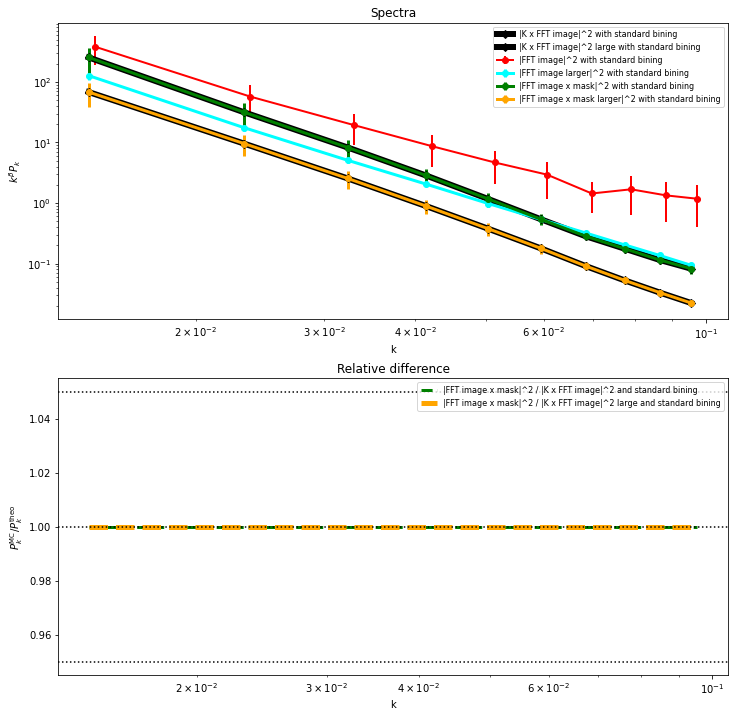

In [24]:
plt.figure(1, figsize=(12,12))
plt.subplot(2,1,1)
plt.errorbar(kvals*1.02, Pk_img_m, Pk_img_s, label='|FFT image|^2 with standard bining', lw=2, marker='o', color='red')
plt.errorbar(kvals, Pk_img_tot_m, Pk_img_tot_s, label='|FFT image larger|^2 with standard bining', lw=3, marker='o', color='cyan')
plt.errorbar(kvals, Pk_ixm_m, Pk_ixm_s, label='|FFT image x mask|^2 with standard bining', lw=3, marker='o', color='green')
plt.errorbar(kvals, Pk_ixm_tot_m, Pk_ixm_tot_s, label='|FFT image x mask larger|^2 with standard bining', lw=3, marker='o', color='orange')
plt.plot(kvals, Pk_D_m, label='|K x FFT image|^2 with standard bining', lw=6, marker='D', color='k')
plt.plot(kvals, Pk_D_tot_m, label='|K x FFT image|^2 large with standard bining', lw=6, marker='D', color='k')
plt.legend(fontsize=8)
plt.xlabel('k')
plt.ylabel(r'$k^{\beta} P_k$')
plt.title('Spectra')
plt.xscale('log')
plt.yscale('log')

plt.subplot(2,1,2)
plt.plot(kvals, Pk_ixm_m/Pk_D_m, label='|FFT image x mask|^2 / |K x FFT image|^2 and standard bining', lw=3, ls='--', color='green')
plt.plot(kvals, Pk_ixm_tot_m/Pk_D_tot_m, label='|FFT image x mask|^2 / |K x FFT image|^2 large and standard bining', lw=5, ls='--', color='orange')
plt.axhline(1, ls=':', color='k')
plt.axhline(0.95, ls=':', color='k')
plt.axhline(1.05, ls=':', color='k')
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('k')
plt.xscale('log')
plt.ylabel(r'$P^{\rm MC}_k/P^{\rm theo}_k$')
plt.title('Relative difference')

print((Pk_ixm_m - Pk_D_m)/Pk_ixm_m)
print((Pk_ixm_tot_m - Pk_D_tot_m)/Pk_ixm_tot_m)

print('Differrence > 1e-14 for small map: ', np.sum(np.abs((Pk_ixm_m - Pk_D_m)/Pk_ixm_m)>1e-14))
print('Differrence > 1e-14 for large map: ', np.sum(np.abs((Pk_ixm_tot_m - Pk_D_tot_m)/Pk_ixm_tot_m)>1e-14))

### Pk checks with |K| x Pk_input and then binned

Text(0.5, 1.0, 'Relative difference')

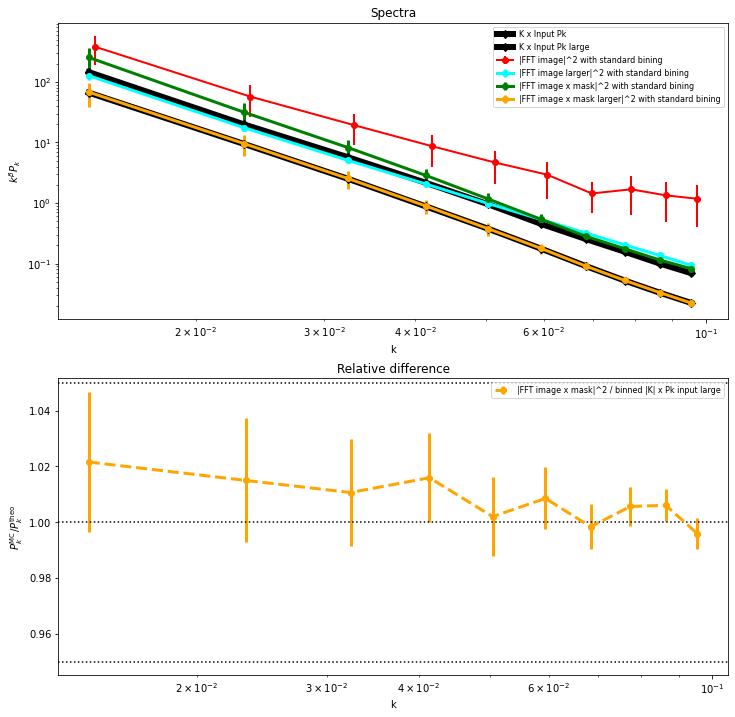

In [25]:
plt.figure(1, figsize=(12,12))
plt.subplot(2,1,1)
plt.errorbar(kvals*1.02, Pk_img_m, Pk_img_s, label='|FFT image|^2 with standard bining', lw=2, marker='o', color='red')
plt.errorbar(kvals, Pk_img_tot_m, Pk_img_tot_s, label='|FFT image larger|^2 with standard bining', lw=3, marker='o', color='cyan')
plt.errorbar(kvals, Pk_ixm_m, Pk_ixm_s, label='|FFT image x mask|^2 with standard bining', lw=3, marker='o', color='green')
plt.errorbar(kvals, Pk_ixm_tot_m, Pk_ixm_tot_s, label='|FFT image x mask larger|^2 with standard bining', lw=3, marker='o', color='orange')
plt.plot(kvals, input_Pk_K, label='K x Input Pk', lw=6, marker='D', color='k')
plt.plot(kvals, input_Pk_K_tot, label='K x Input Pk large', lw=6, marker='D', color='k')
plt.legend(fontsize=8)
plt.xlabel('k')
plt.ylabel(r'$k^{\beta} P_k$')
plt.title('Spectra')
plt.xscale('log')
plt.yscale('log')

plt.subplot(2,1,2)
#plt.errorbar(kvals, Pk_ixm_m/input_Pk_K, Pk_ixm_s/Nmc**0.5/input_Pk_K, label='|FFT image x mask|^2 / binned |K| x Pk input', lw=3, marker='o', ls='--', color='green')
plt.errorbar(kvals, Pk_ixm_tot_m/input_Pk_K_tot, Pk_ixm_tot_s/Nmc**0.5/input_Pk_K_tot, label='|FFT image x mask|^2 / binned |K| x Pk input large', lw=3, ls='--', marker='o', color='orange')
plt.axhline(1, ls=':', color='k')
plt.axhline(0.95, ls=':', color='k')
plt.axhline(1.05, ls=':', color='k')
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('k')
plt.xscale('log')
plt.ylabel(r'$P^{\rm MC}_k/P^{\rm theo}_k$')
plt.title('Relative difference')

Text(0, 0.5, 'PDF')

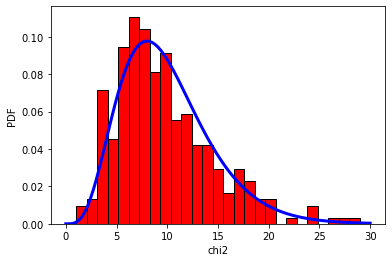

In [26]:
#===== Test if model and data are compatible statistically
invcov = np.linalg.inv(cov_imx_tot)
chi2 = np.zeros(Nmc)
for imc in range(Nmc):
    chi2[imc] = np.matmul((Pk_ixm_tot_mc[imc,:]-input_Pk_K_tot), np.matmul(invcov, (Pk_ixm_tot_mc[imc,:]-input_Pk_K_tot)))

xsample = np.linspace(0, len(kvals)*3, 100)
bins = np.linspace(0,len(kvals)*3, 30)
pdf = stats.chi2.pdf(xsample, df=len(kvals))

plt.hist(chi2, bins=bins, color='r', density=True, ec='k')
plt.plot(xsample, pdf, lw=3, color='blue')
plt.xlabel('chi2')
plt.ylabel('PDF')

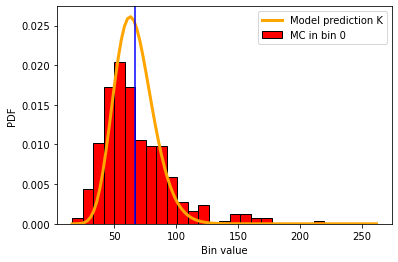

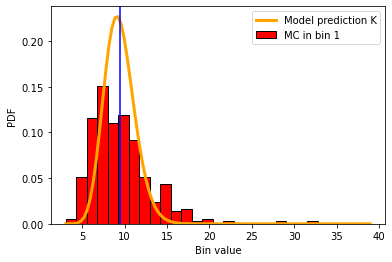

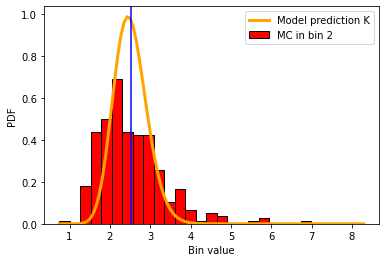

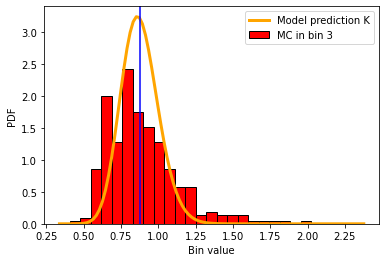

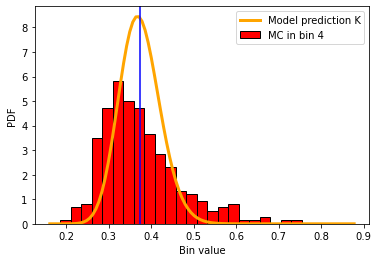

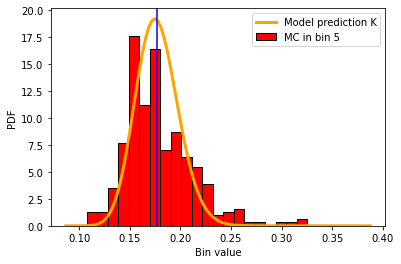

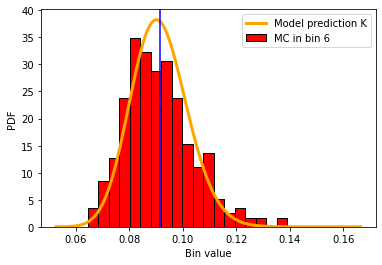

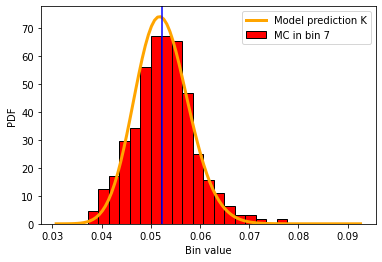

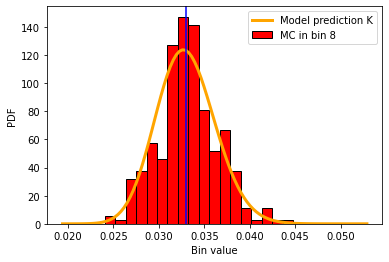

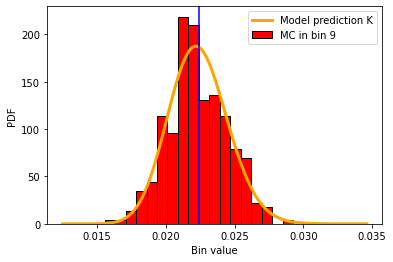

In [27]:
for i in range(len(input_Pk_K_tot)):
    plt.figure(i)
    sigK = input_Pk_K_tot[i]**0.5
    
    xsample = np.linspace(np.amin(Pk_ixm_tot_mc[:,i])*0.8, np.amax(Pk_ixm_tot_mc[:,i])*1.2, 100)
    bins = np.linspace(np.amin(Pk_ixm_tot_mc[:,i])*0.8, np.amax(Pk_ixm_tot_mc[:,i])*1.2, 30)
    pdfK = stats.chi2.pdf(xsample, df=kbin_counts[i], scale=sigK**2/kbin_counts[i])
    plt.plot(xsample, pdfK, lw=3, color='orange', label='Model prediction K')
    
    plt.hist(Pk_ixm_tot_mc[:,i], bins=bins, color='r', density=True, ec='k', label='MC in bin '+str(i))
    plt.axvline(sigK**2, color='b')
    plt.xlabel('Bin value')
    plt.ylabel('PDF')
    plt.legend()

### Pk checks with Mbb x Pk_input

Text(0.5, 1.0, 'Relative difference')

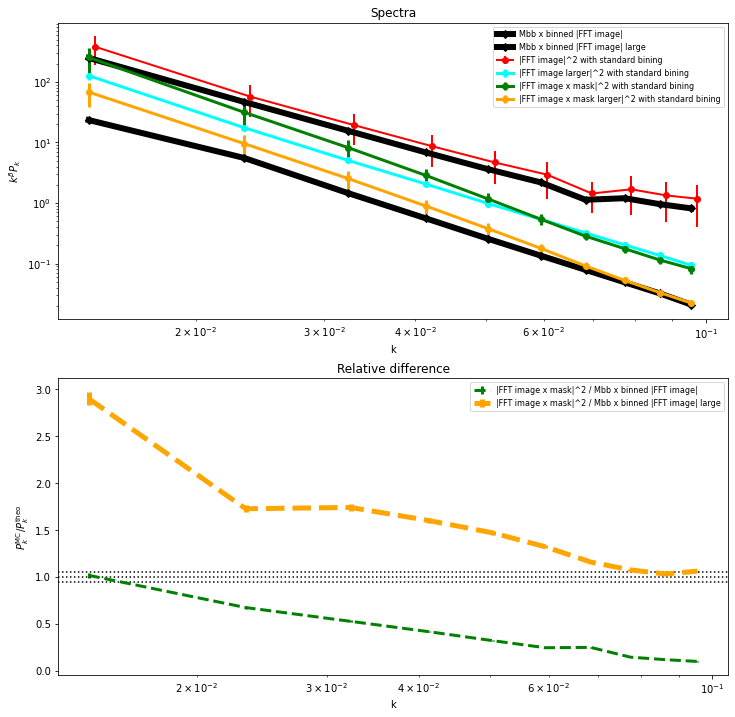

In [28]:
plt.figure(1, figsize=(12,12))
plt.subplot(2,1,1)
plt.errorbar(kvals*1.02, Pk_img_m, Pk_img_s, label='|FFT image|^2 with standard bining', lw=2, marker='o', color='red')
plt.errorbar(kvals, Pk_img_tot_m, Pk_img_tot_s, label='|FFT image larger|^2 with standard bining', lw=3, marker='o', color='cyan')
plt.errorbar(kvals, Pk_ixm_m, Pk_ixm_s, label='|FFT image x mask|^2 with standard bining', lw=3, marker='o', color='green')
plt.errorbar(kvals, Pk_ixm_tot_m, Pk_ixm_tot_s, label='|FFT image x mask larger|^2 with standard bining', lw=3, marker='o', color='orange')
plt.plot(kvals, Pk_Mbb_m, label='Mbb x binned |FFT image|', lw=6, marker='D', color='k')
plt.plot(kvals, Pk_Mbb_tot_m, label='Mbb x binned |FFT image| large', lw=6, marker='D', color='k')
plt.legend(fontsize=8)
plt.xlabel('k')
plt.ylabel(r'$k^{\beta} P_k$')
plt.title('Spectra')
plt.xscale('log')
plt.yscale('log')

plt.subplot(2,1,2)
plt.errorbar(kvals, Pk_ixm_m/Pk_Mbb_m, Pk_ixm_s/Nmc**0.5/Pk_Mbb_m, label='|FFT image x mask|^2 / Mbb x binned |FFT image|', lw=3, ls='--', color='green')
plt.errorbar(kvals, Pk_ixm_tot_m/Pk_Mbb_tot_m, Pk_ixm_tot_s/Nmc**0.5/Pk_Mbb_tot_m, label='|FFT image x mask|^2 / Mbb x binned |FFT image| large', lw=5, ls='--', color='orange')
plt.axhline(1, ls=':', color='k')
plt.axhline(0.95, ls=':', color='k')
plt.axhline(1.05, ls=':', color='k')
plt.legend(loc='upper right', fontsize=8)
plt.xlabel('k')
plt.xscale('log')
plt.ylabel(r'$P^{\rm MC}_k/P^{\rm theo}_k$')
plt.title('Relative difference')
